In [8]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')

In [9]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.zip')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [10]:
print(shoppers_data.shape)

(12330, 18)


In [11]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [12]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


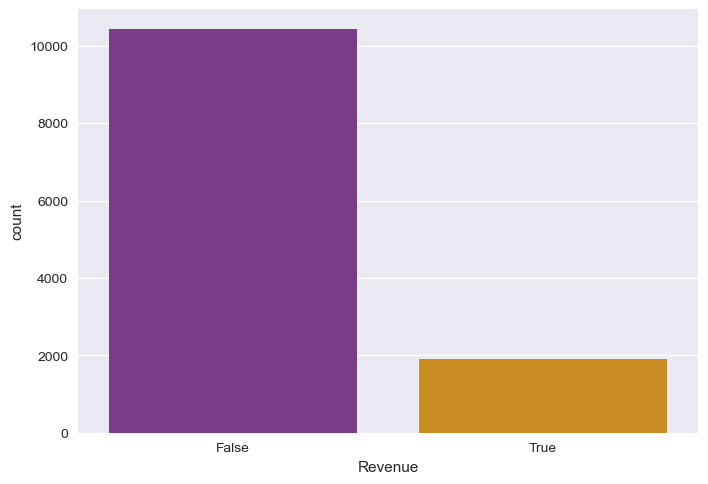

In [13]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

In [14]:
#По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

- Разделим выборку на тренировочную и тестовую.
- Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:

- значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
- значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

##### Задание 6.2

Для начала позаботимся о создании отложенной тестовой выборки.

Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку. В качестве значения параметра random_state возьмите число 42.

Чему равно количество сессий на сайте в тренировочной и тестовой выборках?

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape[0])
print(X_test.shape[0])

9864
2466


#### Задание 6.3
Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — -score.

Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
#Создаём модель
model_test = ensemble.RandomForestClassifier(
    #n_estimators=500, #число деревьев
    #criterion='entropy', #критерий эффективности
    #max_depth=3, #максимальная глубина дерева
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)

#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_test, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([1.43956542, 1.30890727, 1.37105489, 1.44637346, 1.37253857]),
 'score_time': array([0.05542064, 0.04899764, 0.04184389, 0.03564596, 0.04394746]),
 'test_score': array([0.64540338, 0.67518248, 0.65497076, 0.6179159 , 0.65441176]),
 'train_score': array([1.        , 0.99959033, 1.        , 1.        , 1.        ])}

In [29]:
round(cv_metrics['train_score'].mean(),2)

np.float64(1.0)

In [33]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

In [32]:
#Создаём список из моделей
models=[
    ensemble.RandomForestClassifier(
    n_estimators=200, #число деревьев
    #criterion='entropy', #критерий эффективности
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf = 5,
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
    ),

    ensemble.RandomForestClassifier(
    n_estimators=200, #число деревьев
    #criterion='entropy', #критерий эффективности
    max_depth=7, #максимальная глубина дерева
    min_samples_leaf=5,
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
    ),

    ensemble.RandomForestClassifier(
    n_estimators=200, #число деревьев
    #criterion='entropy', #критерий эффективности
    max_depth=12, #максимальная глубина дерева
    min_samples_leaf=5,
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
    )

]

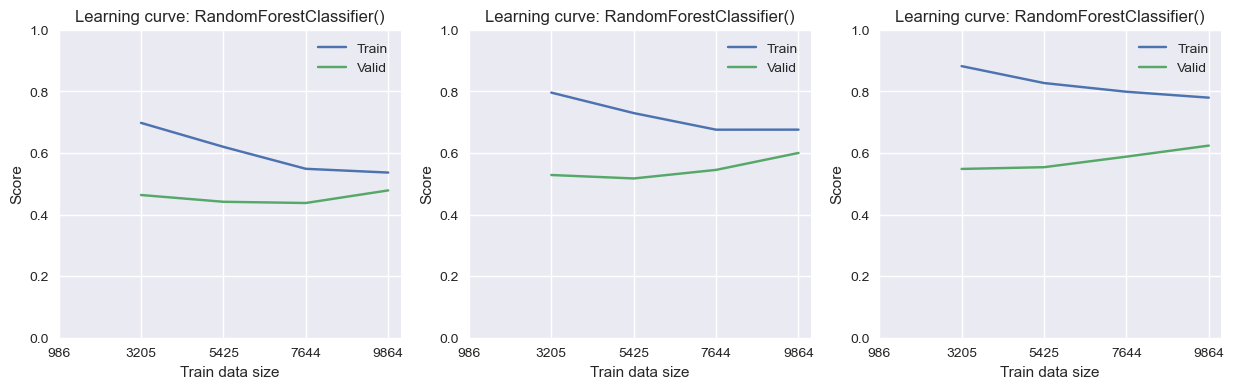

In [ ]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y,
        skf,
        ax=axes[i],
        title=model.__class__.__name__ + '()'
)

In [41]:
opti_forest = ensemble.RandomForestClassifier(
    n_estimators=200, #число деревьев
    #criterion='entropy', #критерий эффективности
    max_depth=7, #максимальная глубина дерева
    min_samples_leaf=5,
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
    )

#Обучаем модель на тренировочной выборке
opti_forest.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_test_pred = opti_forest.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Thresholds: [0.0016146  0.00183509 0.00191163 0.00191452 0.00194508]
Precision scores: [0.15470397 0.15471966 0.15473535 0.15475104 0.15476673]
Recall scores: [1. 1. 1. 1. 1.]
Best threshold = 0.36, F1-Score = 0.69


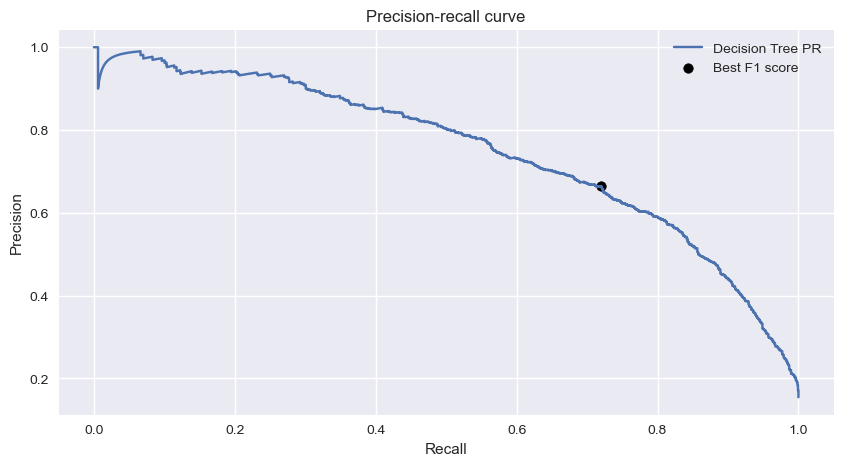

In [ ]:
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(opti_forest, X_train, y_train, cv=skf, method='predict_proba')
#Выделяем столбец с вероятностями для класса 1
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [44]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_test_pred_proba = opti_forest.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.95      0.92      0.93      2084
        True       0.63      0.72      0.67       382

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.90      0.89      0.89      2466

